<a href="https://colab.research.google.com/github/Dhruvsandhu1/Computer-Vision-Transfer-Learning/blob/main/Resnet_Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [27]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
import numpy as np

import glob
import matplotlib.pyplot as plt
import itertools

In [9]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 128

In [10]:
!wget -nc https://archive.org/download/fruits-360/fruits-360.zip

--2025-06-30 12:34:42--  https://archive.org/download/fruits-360/fruits-360.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801203.us.archive.org/24/items/fruits-360/fruits-360.zip [following]
--2025-06-30 12:34:44--  https://ia801203.us.archive.org/24/items/fruits-360/fruits-360.zip
Resolving ia801203.us.archive.org (ia801203.us.archive.org)... 207.241.228.23
Connecting to ia801203.us.archive.org (ia801203.us.archive.org)|207.241.228.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  82.3MB/s    in 2.2s    

2025-06-30 12:34:46 (82.3 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [11]:
!unzip -nq fruits-360.zip

In [13]:
!ls

fruits-360  fruits-360.zip  sample_data


In [14]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [16]:
!ls {train_path}

'Apple Braeburn'       'Cactus fruit'	    Kiwi	     Pear
'Apple Golden 1'        Carambula	    Kumquats	    'Pear Abate'
'Apple Golden 2'        Cherry		    Lemon	    'Pear Monster'
'Apple Golden 3'        Clementine	   'Lemon Meyer'    'Pear Williams'
'Apple Granny Smith'    Cocos		    Limes	     Pepino
'Apple Red 1'	        Dates		    Litchi	     Pineapple
'Apple Red 2'	        Granadilla	    Mandarine	    'Pitahaya Red'
'Apple Red 3'	       'Grapefruit Pink'    Mango	     Plum
'Apple Red Delicious'  'Grapefruit White'   Maracuja	     Pomegranate
'Apple Red Yellow'     'Grape Pink'	    Nectarine	     Quince
 Apricot	       'Grape White'	    Orange	     Raspberry
 Avocado	       'Grape White 2'	    Papaya	     Salak
'Avocado ripe'	        Guava		   'Passion Fruit'   Strawberry
 Banana		        Huckleberry	    Peach	     Tamarillo
'Banana Red'	        Kaki		   'Peach Flat'      Tangelo


In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  image_size=IMAGE_SIZE,
  batch_size=batch_size
)

Found 28736 files belonging to 60 classes.
Found 9673 files belonging to 60 classes.


In [19]:
class_names=train_ds.class_names
K=len(class_names)
class_names

['Apple Braeburn',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Red',
 'Cactus fruit',
 'Carambula',
 'Cherry',
 'Clementine',
 'Cocos',
 'Dates',
 'Granadilla',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Litchi',
 'Mandarine',
 'Mango',
 'Maracuja',
 'Nectarine',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Peach Flat',
 'Pear',
 'Pear Abate',
 'Pear Monster',
 'Pear Williams',
 'Pepino',
 'Pineapple',
 'Pitahaya Red',
 'Plum',
 'Pomegranate',
 'Quince',
 'Raspberry',
 'Salak',
 'Strawberry',
 'Tamarillo',
 'Tangelo']

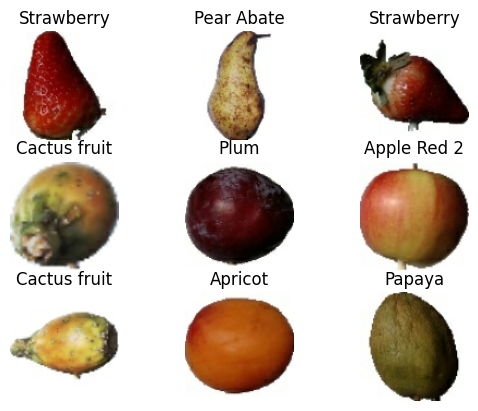

In [21]:
#Lets visualize the data
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
# configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds_unshuffled = train_ds.cache().prefetch(buffer_size=AUTOTUNE) # eval
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  ]
)

In [37]:
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [38]:
# don't train existing weights ie freezing all the existing weights
for layer in res.layers:
  layer.trainable = False

In [39]:
#Building the model
i=Input(shape=IMAGE_SIZE+[3])
x=preprocess_input(i)
x=data_augmentation(x)
x=res(x)
x=Flatten()(x)
x=Dense(K,activation='softmax')(x)

In [44]:
model=Model(inputs=i,outputs=x,name="Custom-Resnet")

In [45]:
model.summary()

Model: "Custom-Resnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 100, 100)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 100, 100)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 100, 100)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 100, 100,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 100,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 100, 100,  │          0 │ add_2[0][0]       │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ sequential_1[0][… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60)        │  1,966,140 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,553,852 (97.48 MB)

 Trainable params: 1,966,140 (7.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [46]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [47]:
r=model.fit(train_ds,validation_data=valid_ds,epochs=epochs)

Epoch 1/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - accuracy: 0.7733 - loss: 2.1585 - val_accuracy: 0.9387 - val_loss: 0.3713
Epoch 2/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.9654 - loss: 0.2222 - val_accuracy: 0.9571 - val_loss: 0.3828
Epoch 3/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.9775 - loss: 0.1494 - val_accuracy: 0.9683 - val_loss: 0.3422
Epoch 4/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9798 - loss: 0.1630 - val_accuracy: 0.9673 - val_loss: 0.3604
Epoch 5/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.9836 - loss: 0.1415 - val_accuracy: 0.9769 - val_loss: 0.1372
Epoch 6/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9838 - loss: 0.1603 - val_accuracy: 0.9603 - val_loss: 0.6976
Epoch 7/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.9866 - loss: 0.1083 - val_accuracy: 0.9734 - val_loss: 0.3033
Epoch 8/16
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9893 - loss: 0

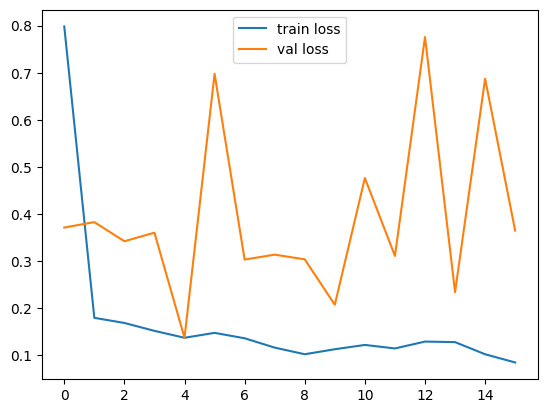

In [48]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

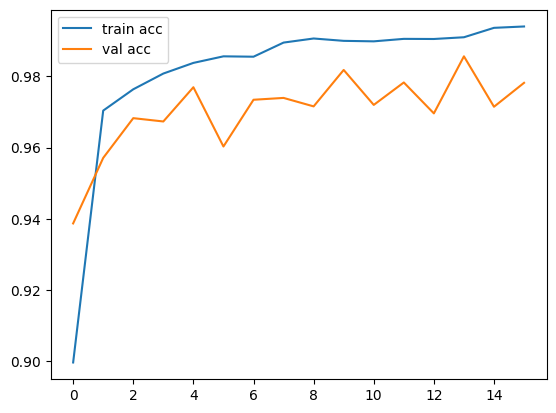

In [50]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [51]:
def get_confusion_matrix(ds):
  # we need to see the data in the same order
  # for both predictions and targets
  # make sure there is no shuffling in ds!
  predictions = np.argmax(model.predict(ds), axis=1)
  targets = ds.map(lambda x, y: y).unbatch()
  targets = np.array([y.numpy() for y in targets])

  cm = confusion_matrix(targets, predictions)
  return cm

In [52]:
cm = get_confusion_matrix(train_ds_unshuffled)
print(cm)

225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 489 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 479]]


In [53]:
valid_cm = get_confusion_matrix(valid_ds)
print(valid_cm)

76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 156 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 143]]


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(15, 15))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 489 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 479]]


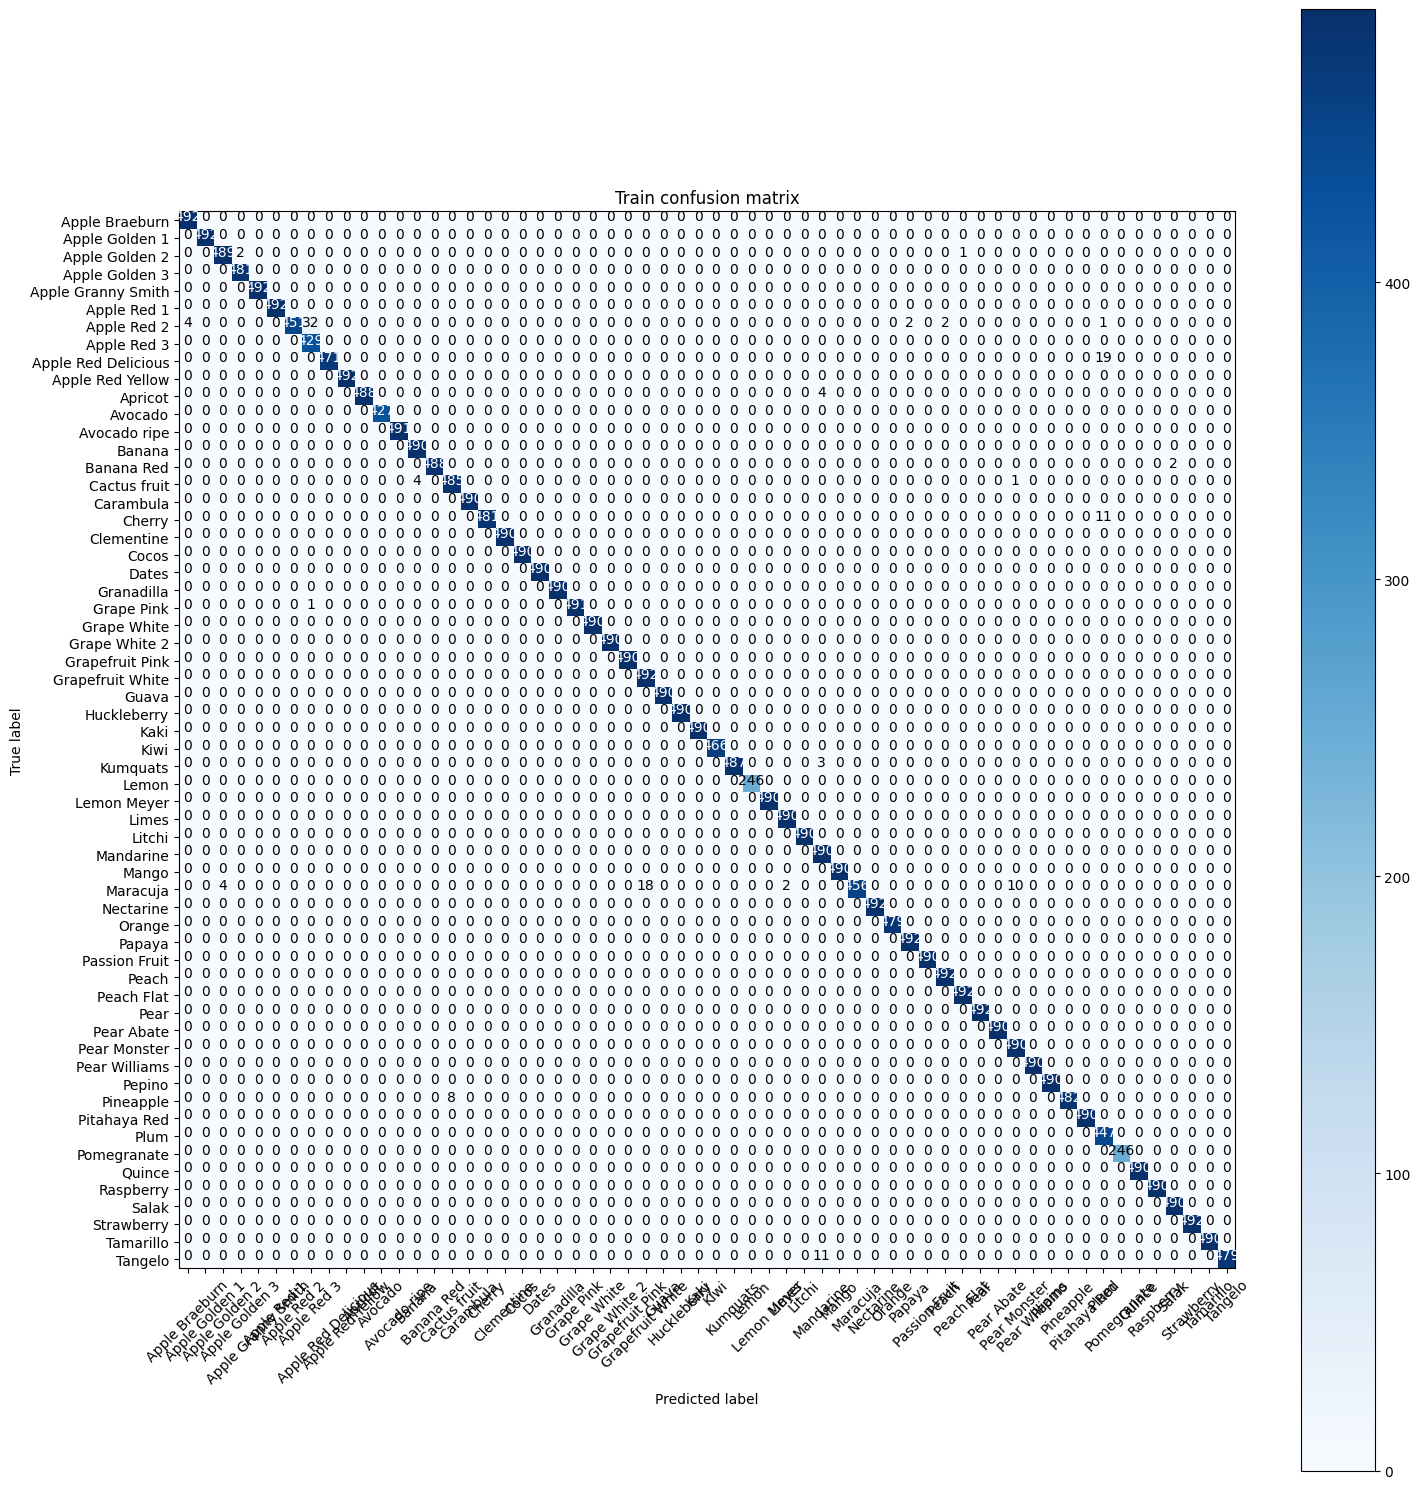

In [55]:
plot_confusion_matrix(cm, class_names, title='Train confusion matrix')